In [11]:
import sys, os, numpy as np, pylab as pl, h5py, traceback, glob
from astropy import units as un, constants as cons
from numpy import log10 as log
from importlib import reload
rpc_hydro_dir = '/home/jonathan/Dropbox/other_repositories/rpc_hydro/'
rpc_hydro_pysrc_dir = rpc_hydro_dir + 'pysrc_new'
project_dir = rpc_hydro_dir+'forCHIMES/'
cross_sections_dir = project_dir + 'cross_sections/'
chimes_dir = '/home/jonathan/Dropbox/other_repositories/chimes/'
chimes_tools_dir = chimes_dir + 'chimes-tools/'
chimes_cross_sections_dir = chimes_dir+ 'chimes-tools/generate_cross_sections/'
sys.path += [rpc_hydro_pysrc_dir,project_dir, chimes_cross_sections_dir,chimes_tools_dir]
import forCHIMES
from parameters import *
from plot_utils import *
from matplotlib import ticker

In [12]:
(1e46*un.erg/un.s/(300e18**2*un.cm**2*4e4*un.cm**-3))

<Quantity 2.77777778 cm erg / s>

In [13]:
sizes = 0.005*1.478758**(np.arange(0,10)+0.5) #default ISM model
print(log(0.5*1e46/(4*np.pi*300e18**2*36*un.eV.to('erg')*3e10)))
lng=2.5

3.407383481652662


In [14]:
Qs_datafile = '/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/RPC/RPC/grainsQs.coutput'
q = np.genfromtxt(Qs_datafile)

In [15]:
graphite_opc_file = '/home/jonathan/research/separate/c17.00/data/graphite_ism_10.opc'
silicate_opc_file = '/home/jonathan/research/separate/c17.00/data/silicate_ism_10.opc'

In [16]:
areas = np.array([float(l.split(' ')[0]) for l in 
                  open(graphite_opc_file,'r').readlines()+open(silicate_opc_file,'r').readlines()
                  if 'total grain area' in l])
areas = np.concatenate([areas[1:11],areas[12:]])
print(areas[:10].sum(),areas[10:].sum())

2.08471825e-21 2.41211443e-21


In [17]:
qq = q[:,1::2]+q[:,2::2] #add absorption and scattering
sigmas = qq*areas #cm^2/H

In [18]:
logEs = log(q[:,0])
dlogEs = np.pad((logEs[:-2]-logEs[2:])/2, 1, 'edge')

[ 0.         15.45430327 15.21574264 14.39100999 13.67532811 13.19602445
 10.04742306  8.04542306 -3.6196152 ] 2.7342658692438696e+29
graphite 9.080516105751285e-22
silicate 8.814707956584642e-22


Text(0, 0.5, 'cumulative opacity $<a\\ [{\\rm cm}^2 {\\rm H}^{-1}]$')

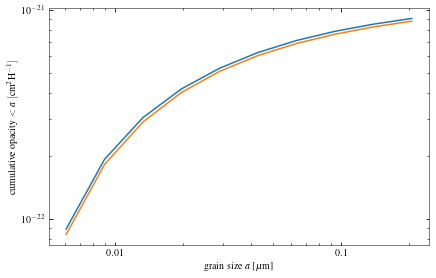

In [22]:
baseSpectrum = forCHIMES.baseSpectrum()
baseSpectrum_logJs = interpolate.interp1d(baseSpectrum[0],baseSpectrum[1],
                                          bounds_error=False,fill_value=MIN_log_flux)(logEs)
ax = pl.subplot(111)
for j,grain in enumerate(('graphite','silicate')):    
    tot = 0.
    avg_sigma = np.array([(10.**baseSpectrum_logJs * sigmas[:,j*10+i] * dlogEs * 10**logEs).sum() /
                        (10.**baseSpectrum_logJs * dlogEs * 10**logEs).sum() for i,size in enumerate(sizes)])
    pl.loglog(sizes,avg_sigma.cumsum(),label=grain)
    tot += avg_sigma.sum()
    print(grain, tot)
pl.xlabel('grain size $a$ [$\mu$m]')
ax.xaxis.set_major_formatter(arilogformatter)
pl.ylabel(r'cumulative opacity $<a\ [{\rm cm}^2 {\rm H}^{-1}]$')

In [24]:
maindir = '/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/AbsorbedSpectra/'
dirnames = glob.glob(maindir+'/AbsorbedSpectra_*_N17.0')

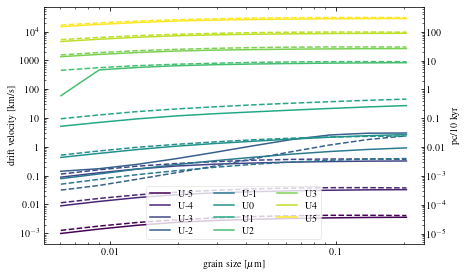

In [52]:
factor = 10000*un.yr.to('s') / un.pc.to('km')
pl.figure(); ax = pl.subplot(111)
for iU,logU in enumerate(range(-5,6)):
    label='U%d'%logU
    logn = lng-logU
    modelname = [s for s in dirnames if label in s][0]
    c=pl.get_cmap('viridis')(iU/10)
    q = np.genfromtxt(modelname+'/grainsDrift.coutput')
    for j,grain in enumerate(('graphite','silicate')):
        pl.loglog(sizes,q[1,1+j*10:1+(j+1)*10],c=c,label=('',label)[j],ls = ('--','-')[j])
pl.legend(ncol=3)
pl.ylabel(r'drift velocity [km/s]')
pl.xlabel('grain size [$\mu$m]')
yls = pl.ylim()
ax.yaxis.set_major_formatter(arilogformatter)
ax.xaxis.set_major_formatter(arilogformatter)
ax2 = pl.twinx()
ax2.set_yscale('log')
pl.ylim(factor * np.array(yls))
pl.ylabel(r'pc/10 kyr')
ax2.yaxis.set_major_formatter(arilogformatter)

In [40]:
import work_paths as wp;runsDir,rpc_hydro_dir=wp.work_paths()

fn_static_solution = rpc_hydro_dir+'forCHIMES/static_solution.npz'
static_solution = np.load(fn_static_solution)


['nHs', 'taus', 'Ts', 'U0s', 'NHs', 'NHIs', 'rs', 'sigmas', 'fHIs']

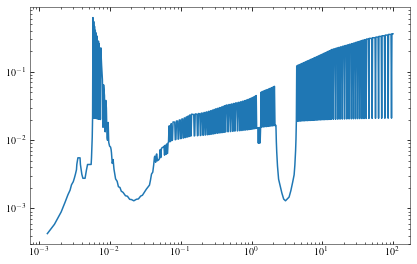

In [46]:
d=5
dlnUs = np.log(static_solution['U0s'][:-d]/static_solution['U0s'][d:])
Umeans = (static_solution['U0s'][:-d]*static_solution['U0s'][d:])**0.5
drs = (static_solution['rs'][d:]-static_solution['rs'][:-d])/100/3e18

pl.loglog(Umeans,drs/dlnUs)

In [44]:
drs

array([-3.08567758e+14, -6.17135516e+14, -9.25703274e+14, ...,
                   nan,             nan,             nan])

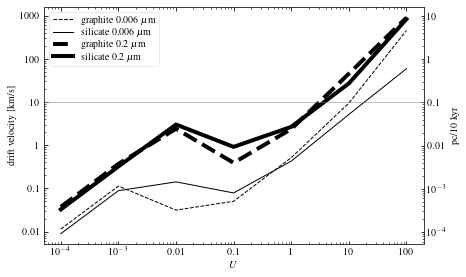

In [31]:
factor = 10000*un.yr.to('s') / un.pc.to('km')
logUs = np.arange(-4,3)
iLines = np.array([1,11,5,15,10,20])
drifts = np.zeros((len(logUs),len(iLines)))
for iU,logU in enumerate(logUs):
    label='U%d'%logU
    logn = lng - logU
    modelname = [s for s in dirnames if label in s][0]
    q = np.genfromtxt(modelname+'/grainsDrift.coutput')    
    drifts[iU,:] = q[1,iLines]
pl.figure(); ax = pl.subplot(111)
for ii,iLine in enumerate(iLines):
    if ii in (2,3): continue
    ls = ('--','-')[ii%2]
    lw = (1,2,4)[ii//2]
    label = r'%s %s $\mu$m'%(('graphite','silicate')[ii%2], nSignificantDigits(sizes[[0,4,9][ii//2]],1,True))
    pl.loglog(10.**logUs, drifts[:,ii],c='k',label=label,ls=ls,lw=lw)
pl.legend()
pl.ylabel(r'drift velocity [km/s]')
pl.xlabel(r'$U$')
yls = pl.ylim()
ax.yaxis.set_major_formatter(arilogformatter)
ax.xaxis.set_major_formatter(arilogformatter)
ax2 = pl.twinx()
ax2.set_yscale('log')
pl.ylim(factor * np.array(yls))
pl.ylabel(r'pc/10 kyr')
ax2.yaxis.set_major_formatter(arilogformatter)
pl.axhline(0.1,lw=0.5,c='.5')

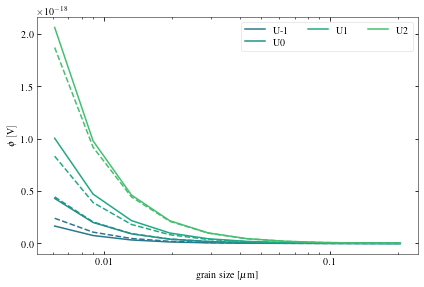

In [52]:
factor = (4*np.pi/3 * sizes**3 * 3/cons.m_p.to('g'))**-1 / 100 # N_particle_dust^-1 d2m
# factor = 1.6e-19 / (sizes*1e-6) * 8.988e9 # k_e * e charge / a
pl.figure(); ax = pl.subplot(111)
for iU,logU in enumerate(range(-1,3)):
    label='U%d'%logU
    logn = lng-logU
    modelname = [s for s in dirnames if label in s][0]
    c=pl.get_cmap('viridis')((iU+4)/10)
    q = np.genfromtxt(modelname+'/grainsCharge.coutput')
    for j,grain in enumerate(('graphite','silicate')):
        pl.semilogx(sizes,factor * q[1,2+j*10:2+(j+1)*10],c=c,label=('',label)[j],ls = ('--','-')[j])
pl.legend(ncol=3)
pl.ylabel(r'$\phi\ [{\rm V}]$')
# pl.ylim(0,115) #as in Weingartner+06
pl.xlabel('grain size [$\mu$m]')
ax.xaxis.set_major_formatter(arilogformatter)

In [70]:
print((8.9889e9*un.Newton * un.m**2  *1.6e-19**2 * 1e-36 * 1e21*un.cm**-2/cons.m_p).to('cm*s**-2'))
print((1e46*un.erg/un.s/(2*300e18**2*un.cm**2*cons.c)*1e-21*un.cm**2/cons.m_p).to('cm*s**-2'))

1.3757791688652355e-10 cm / s2
0.0011079215427977442 cm / s2


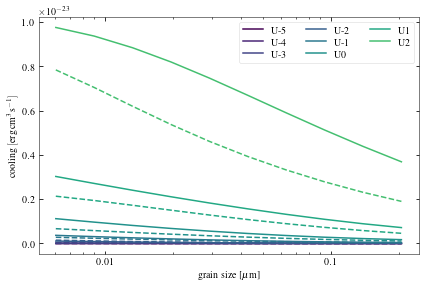

In [45]:
pl.figure(); ax = pl.subplot(111)
for iU,logU in enumerate(range(-5,3)):
    label='U%d'%logU
    logn = lng-logU
    modelname = [s for s in dirnames if label in s][0]
    c=pl.get_cmap('viridis')(iU/10)
    q = np.genfromtxt(modelname+'/grainsHeating.coutput')
    for j,grain in enumerate(('graphite','silicate')):
        pl.semilogx(sizes,(10**logn)**-2 * q[1,1+j*10:1+(j+1)*10],c=c,label=('',label)[j],ls = ('--','-')[j])
pl.legend(ncol=3)
pl.ylabel(r'cooling $[{\rm erg}\,{\rm cm}^{3}\,{\rm s}^{-1}]$')
pl.xlabel('grain size [$\mu$m]')
ax.xaxis.set_major_formatter(arilogformatter)

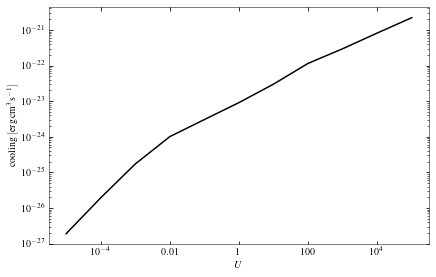

In [51]:
logUs = np.arange(-5,6)
cooling = np.zeros(len(logUs))
for iU,logU in enumerate(logUs):
    label='U%d'%logU
    logn = lng - logU
    modelname = [s for s in dirnames if label in s][0]
    q = np.genfromtxt(modelname+'/grainsHeating.coutput')    
    cooling[iU] = (10**logn)**-2 * q[1,1:].sum()
pl.figure(); ax = pl.subplot(111)
pl.loglog(10.**logUs, cooling,c='k')
pl.ylabel(r'cooling $[{\rm erg}\,{\rm cm}^{3}\,{\rm s}^{-1}]$')
pl.xlabel(r'$U$')
ax.xaxis.set_major_formatter(arilogformatter)

In [22]:
maindir = '/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/'
dirnames = glob.glob(maindir+'/constantDensity_*')

/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L45.7/grainsCharge.coutput"
  
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L44.7/grainsCharge.coutput"
  
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L43.7/grainsCharge.coutput"
  
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L42.7/grain

Text(0.5, 0, '$N_{\\rm H}\\ [{\\rm cm}^{-2}]$')

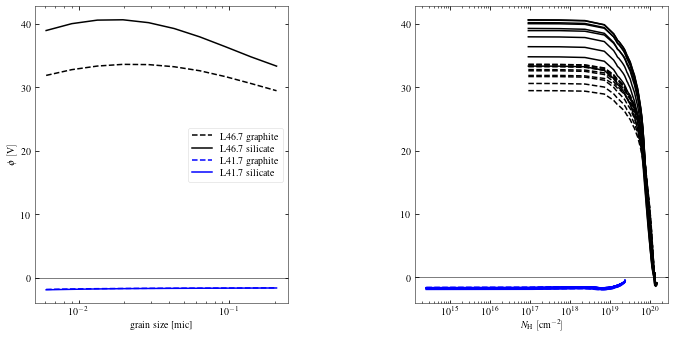

In [25]:
factor = 1.6e-19 / (sizes*1e-6) * 8.988e9 # k_e * e charge / a
pl.figure(figsize=(10,5)); pl.subplots_adjust(wspace=0.5)
axs = [pl.subplot(1,2,i+1) for i in range(2)]
iPanel=0
for imodel,modelname in enumerate(dirnames):
    q = np.genfromtxt(modelname+'/grainsCharge.coutput')
    if len(q.shape)==2:
        for j,grain in enumerate(('graphite','silicate')):
            pl.sca(axs[0])
            label=modelname.split('/')[-1].split('_')[-1] + ' ' + grain            
            pl.semilogx(sizes,factor * q[1,2+j*10:2+(j+1)*10],c='kb'[iPanel],label=label,ls = ('--','-')[j])
            pl.sca(axs[1])
            for isize in range(10):
                pl.semilogx(10**3.5*q[:,0],factor[isize] * q[:,2+j*10+isize],c='kb'[iPanel],ls = ('--','-')[j])

        iPanel+=1
pl.sca(axs[0])
pl.legend()
pl.ylabel(r'$\phi\ [{\rm V}]$')
pl.xlabel('grain size [mic]')
pl.axhline(0,lw=0.5,c='k')
pl.sca(axs[1])
pl.axhline(0,lw=0.5,c='k')
pl.xlabel(r'$N_{\rm H}\ [{\rm cm}^{-2}]$')

/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L45.7/grainsHeating.coutput"
  
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L44.7/grainsHeating.coutput"
  
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L43.7/grainsHeating.coutput"
  
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L42.7/gr

Text(0.5, 0, '$N_{\\rm H}\\ [{\\rm cm}^{-2}]$')

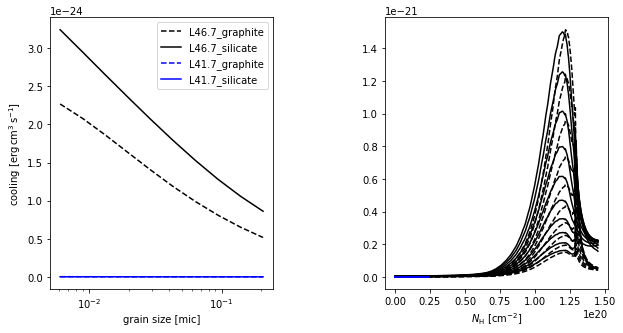

In [110]:
factor = (10**3.5)**-2 # n_H^-2
pl.figure(figsize=(10,5)); pl.subplots_adjust(wspace=0.5)
axs = [pl.subplot(1,2,i+1) for i in range(2)]
iPanel=0
for imodel,modelname in enumerate(dirnames):
    q = np.genfromtxt(modelname+'/grainsHeating.coutput')
    if len(q.shape)==2:
        for j,grain in enumerate(('graphite','silicate')):
            pl.sca(axs[0])
            label=modelname.split('/')[-1].split('_')[-1] + '_' + grain            
            pl.semilogx(sizes,factor * q[1,1+j*10:1+(j+1)*10],c='kb'[iPanel],label=label,ls = ('--','-')[j])
            pl.sca(axs[1])
            for isize in range(10):
                pl.plot(q[:,0]*10**3.5,factor * q[:,1+j*10+isize],c='kb'[iPanel],ls = ('--','-')[j])

        iPanel+=1
pl.sca(axs[0])
pl.legend()
pl.ylabel(r'cooling $[{\rm erg}\,{\rm cm}^{3}\,{\rm s}^{-1}]$')
pl.xlabel('grain size [mic]')
pl.sca(axs[1])
pl.xlabel(r'$N_{\rm H}\ [{\rm cm}^{-2}]$')
# pl.axhline(0,lw=0.5,c='k')

/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L45.7/hydrogen.coutput"
  after removing the cwd from sys.path.
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L44.7/hydrogen.coutput"
  after removing the cwd from sys.path.
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: genfromtxt: Empty input file: "/home/jonathan/Dropbox/other_repositories/rpc_hydro/CloudyRuns/constantDensity/constantDensity_a-1.4_L43.7/hydrogen.coutput"
  after removing the cwd from sys.path.
/home/jonathan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: genfromtxt: Empty input file: "/home/jonatha

Text(0.5, 0, '$N_{\\rm H}\\ [{\\rm cm}^{-2}]$')

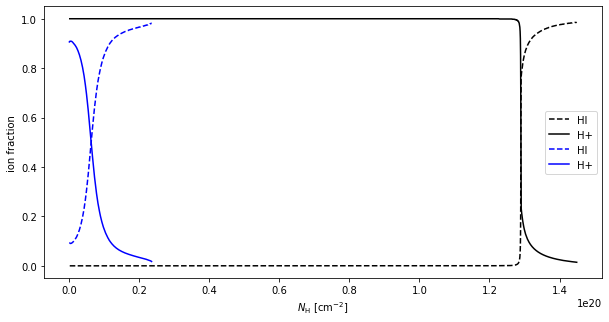

In [109]:
pl.figure(figsize=(10,5)); pl.subplots_adjust(wspace=0.5)
iPanel = 0
for imodel,modelname in enumerate(dirnames):
    q = np.genfromtxt(modelname+'/hydrogen.coutput')
    if len(q.shape)==2:
        for icol in range(2):
            label = ('HI','H+','H2')[icol]
            pl.plot(q[:,0]*10**3.5,q[:,icol+1],c='kb'[iPanel],ls = ('--','-',':')[icol],label=label)
        iPanel+=1
pl.legend()
pl.ylabel(r'ion fraction')
pl.xlabel(r'$N_{\rm H}\ [{\rm cm}^{-2}]$')